Construindo vocabulário a partir do conjunto de treino...
Vocabulário construído com 101 tokens mais frequentes.
Usando dispositivo: cuda
Epoch 1/200 - Loss: 0.6957 - Val Acc: 0.5000 - Val Prec: 0.0000
Epoch 2/200 - Loss: 0.6935 - Val Acc: 0.5100 - Val Prec: 0.5051
Epoch 3/200 - Loss: 0.6925 - Val Acc: 0.5100 - Val Prec: 0.5051
Epoch 4/200 - Loss: 0.6968 - Val Acc: 0.5400 - Val Prec: 0.5208
Epoch 5/200 - Loss: 0.6914 - Val Acc: 0.5000 - Val Prec: 0.0000
Epoch 6/200 - Loss: 0.6733 - Val Acc: 0.5300 - Val Prec: 0.5155
Epoch 7/200 - Loss: 0.6560 - Val Acc: 0.6000 - Val Prec: 0.5714
Epoch 8/200 - Loss: 0.6395 - Val Acc: 0.6300 - Val Prec: 0.5890
Epoch 9/200 - Loss: 0.5984 - Val Acc: 0.5900 - Val Prec: 0.5495
Epoch 10/200 - Loss: 0.6265 - Val Acc: 0.5500 - Val Prec: 0.5263
Epoch 11/200 - Loss: 0.6509 - Val Acc: 0.6500 - Val Prec: 0.8571
Epoch 12/200 - Loss: 0.6317 - Val Acc: 0.7200 - Val Prec: 0.6618
Epoch 13/200 - Loss: 0.5402 - Val Acc: 0.8200 - Val Prec: 0.8200
Epoch 14/200 - Loss: 0.387

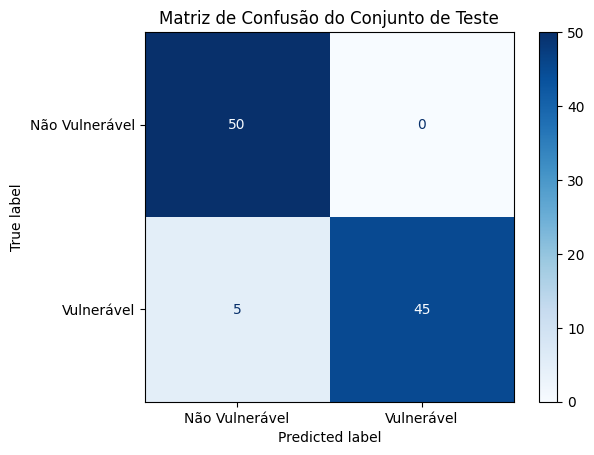

Total de logits obtidos: 100 amostras, 2 classes.
Primeiras 10 linhas de logits:
tensor([[-4.3608,  4.4112],
        [-3.7462,  3.9963],
        [-4.3594,  4.4109],
        [ 0.0243, -0.2212],
        [ 1.6355, -1.9354],
        [ 0.7609, -0.7530],
        [ 0.0428, -0.2415],
        [-4.3672,  4.4165],
        [ 5.1089, -4.8445],
        [ 5.0027, -4.7874]])

Novas colunas (logits, probabilidades) adicionadas ao test_df (primeiras 5 linhas):
                                  file_content_in_il  vulnerable  \
0  class class_name1\r\n  private var1\r\n  publi...           1   
1  var1 array\r\nvar1_0\r\nvar1_1 GET\r\nvar1_2\r...           1   
2  class class_name1\r\n  private var1\r\n  publi...           1   
3  var1 POST\r\nvar2 unserialize var1\r\nvar2 mys...           0   
4  var1 POST\r\nvar2 unserialize var1\r\nvar2 mys...           0   

   logit_non_vulnerable  logit_vulnerable  prob_non_vulnerable  \
0             -4.360761          4.411232             0.000155   
1           

In [ ]:
# %pip install transformers
# %pip install datasets
# %pip install accelerate
# %pip install transformers[sentencepiece]
# %pip install torch
# %pip install scikit-learn
# %pip install evaluate
# %pip install nltk
# %pip install pandas
# %pip install sklearn
# %pip install matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score # Importações adicionadas
import matplotlib.pyplot as plt # Importado para exibir gráficos

def load_data():
    # Carregar DataFrames (este bloco está OK)
    train_nvuln_df = pd.read_csv('../data/csv/train_com_id_il_nvuln.csv')
    train_vuln_df = pd.read_csv('../data/csv/train_com_id_il_vuln.csv')
    test_nvuln_df = pd.read_csv('../data/csv/test_com_id_il_nvuln.csv')
    test_vuln_df = pd.read_csv('../data/csv/test_com_id_il_vuln.csv')

    train_df = pd.concat([train_nvuln_df, train_vuln_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    test_df = pd.concat([test_nvuln_df, test_vuln_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

    train_df['vulnerable'] = train_df['vulnerable'].astype(int)
    test_df['vulnerable'] = test_df['vulnerable'].astype(int)
    train_df, val_df = train_test_split(train_df, test_size=1/9, random_state=42, shuffle=True, stratify=train_df['vulnerable'])

    return train_df, val_df, test_df

def encode_snippet(snippet, vocab_map, max_len=77):
    tokens = snippet.split()
    token_ids = [vocab_map.get(token, 0) for token in tokens]
    if len(token_ids) > max_len:
        return token_ids[:max_len]
    else:
        return token_ids + [0] * (max_len - len(token_ids))

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {'input_ids': encodings} # Mantém o dicionário para compatibilidade
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
        # **ALTERAÇÃO CRUCIAL AQUI:** Labels devem ser torch.long para CrossEntropyLoss
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item # Retorna um dicionário

    def __len__(self):
        return len(self.labels)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim) # output_dim = 2 é o que você precisa
        
    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        final_output = lstm_out[:, -1, :] 
        out = self.fc(final_output)
        # **REMOVIDO:** return self.sigmoid(out).squeeze(1)
        # **ALTERAÇÃO CRUCIAL AQUI:** Retorna os logits brutos (batch_size, 2)
        return out 

def evaluate_model(model, data_loader, device, validation=False):
    model.eval()
    # **ALTERAÇÃO CRUCIAL AQUI:** Usar CrossEntropyLoss
    criterion = torch.nn.CrossEntropyLoss() 

    all_predictions = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader: # Batch é um dicionário aqui
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device) # Labels já são long do CustomDataset

            outputs = model(input_ids) # Estes são os LOGITS (shape: batch_size, 2)
            
            loss = criterion(outputs, labels) 
            total_loss += loss.item()

            # Para obter as previsões, aplicar argmax nos logits
            predictions = torch.argmax(outputs, dim=1) # Retorna o índice da classe com o maior logit
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Cálculos das métricas globais
    accuracy = (np.array(all_predictions) == np.array(all_labels)).sum() / len(all_labels)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    avg_loss = total_loss / len(data_loader)

    if validation:
        return avg_loss, accuracy, precision 

    print(f'Test Accuracy: {accuracy:.5f}')
    print(f'Test Precision: {precision:.5f}')
    print(f'Test Recall: {recall:.5f}')
    print(f'Test F1: {f1:.5f}')

    # Gerar a matriz de confusão
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Não Vulnerável", "Vulnerável"])
    disp.plot(cmap="Blues")
    plt.title("Matriz de Confusão do Conjunto de Teste")
    plt.show() # Garante que o plot é exibido
    
    return accuracy, precision, recall, f1

def train_model(model, train_loader, val_loader, epochs, lr, device):
    # **ALTERAÇÃO CRUCIAL AQUI:** Usar CrossEntropyLoss
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader: # Batch é um dicionário aqui
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device) # Labels já são long do CustomDataset

            optimizer.zero_grad()
            outputs = model(input_ids) # Estes são os LOGITS

            # **ALTERAÇÃO CRUCIAL AQUI:** CrossEntropyLoss espera logits e labels long
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss, val_acc, val_prec = evaluate_model(model, val_loader, device, validation=True)
        print(f'Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f} - Val Acc: {val_acc:.4f} - Val Prec: {val_prec:.4f}')

def get_logits_per_class(model, data_loader, device):
    """
    Executa o modelo nos dados fornecidos e retorna os logits brutos para cada classe.
    """
    model.eval() # Coloca o modelo em modo de avaliação
    all_logits = []
    with torch.no_grad(): # Desativa o cálculo de gradientes
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device) # Acessa pelo nome da chave no dicionário
            logits_batch = model(input_ids) # Obtém os logits diretamente
            all_logits.append(logits_batch.cpu()) 
            
    final_logits_tensor = torch.cat(all_logits, dim=0)
    print(f"Total de logits obtidos: {final_logits_tensor.shape[0]} amostras, {final_logits_tensor.shape[1]} classes.")
    return final_logits_tensor

def train_test_and_save():
    # Carregar os dados
    train_df, val_df, test_df = load_data()
    all_train_tokens = []
    for snippet in train_df['file_content_in_il']:
        all_train_tokens.extend(snippet.split())

    counter = Counter(all_train_tokens)
    vocab_size_limit = 5000 
    vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.most_common(vocab_size_limit))}

    train_encodings = [encode_snippet(snippet, vocab) for snippet in train_df['file_content_in_il']]
    val_encodings = [encode_snippet(snippet, vocab) for snippet in val_df['file_content_in_il']]
    test_encodings = [encode_snippet(snippet, vocab) for snippet in test_df['file_content_in_il']]

    # Definição do Device e Hiperparâmetros (este bloco está OK, apenas movido para a ordem correta)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Usando dispositivo: {device}")

    # Hiperparâmetros
    vocab_size = len(vocab) + 1 # Usa o vocab que já foi construído
    embedding_dim = 64
    hidden_dim = 64
    num_layers = 5
    output_dim = 2 # Perfeito para logits de 2 classes
    dropout = 0.5
    lr = 0.003
    epochs = 200
    batch_size = 77

    # Criação de Datasets e DataLoaders (este bloco está OK)
    train_dataset = CustomDataset(train_encodings, train_df['vulnerable'].tolist())
    val_dataset = CustomDataset(val_encodings, val_df['vulnerable'].tolist())
    test_dataset = CustomDataset(test_encodings, test_df['vulnerable'].tolist())

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size) # Usar batch_size aqui também é mais seguro
    test_loader = DataLoader(test_dataset, batch_size=batch_size) # Usar batch_size aqui também é mais seguro

    # Criar e Treinar/Avaliar o modelo
    model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout)
    train_model(model, train_loader, val_loader, epochs, lr, device)
    evaluate_model(model, test_loader, device)

    model_save_path = "lstm_model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"\nModelo final guardado em: {model_save_path}")


    # A partir daqui obtém-se os logits de novas instâncias

    # ----------------- #
    inference_dataset = CustomDataset(test_encodings, test_df['vulnerable'].tolist())
    # Usar um batch_size que pegue todo o dataset de uma vez é bom para inferência se a memória permitir.
    inference_loader = DataLoader(inference_dataset, batch_size=len(inference_dataset), shuffle=False)

    logits_for_new_instances = get_logits_per_class(model, inference_loader, device)

    print("Primeiras 10 linhas de logits:")
    print(logits_for_new_instances[:10])

    # Extrair os logits para cada classe e adicionar ao DataFrame
    logit_non_vulnerable = logits_for_new_instances[:, 0].cpu().numpy()
    logit_vulnerable = logits_for_new_instances[:, 1].cpu().numpy()

    # Calcular probabilidades (se precisar delas para a heurística)
    probabilities_per_class = torch.softmax(logits_for_new_instances, dim=1)
    prob_non_vulnerable = probabilities_per_class[:, 0].cpu().numpy()
    prob_vulnerable = probabilities_per_class[:, 1].cpu().numpy()

    if logits_for_new_instances.shape[0] == len(test_df):
        test_df['logit_non_vulnerable'] = logit_non_vulnerable
        test_df['logit_vulnerable'] = logit_vulnerable
        test_df['prob_non_vulnerable'] = prob_non_vulnerable
        test_df['prob_vulnerable'] = prob_vulnerable
        
        print("\nNovas colunas (logits, probabilidades) adicionadas ao test_df (primeiras 5 linhas):")
        print(test_df[['file_content_in_il', 'vulnerable', 
                    'logit_non_vulnerable', 'logit_vulnerable',
                    'prob_non_vulnerable', 'prob_vulnerable']].head())
    else:
        print("Número de logits do modelo não corresponde ao número de linhas no test_df. Verifique a consistência dos dados.")

    # ----------------- #


    